<a href="https://colab.research.google.com/github/aralbright/2021_AAMSME/blob/main/notebooks/novosparc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Novosparc

Input: adata_corrected.h5ad

Result: 

In [1]:
!pip install anndata
!pip install color_tol
!pip install scanpy
!pip install novosparc

In [2]:
# Setup
%matplotlib inline
import novosparc

import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import altair as alt
from color_tol import qualitative
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr

import random
random.seed(0)

In [3]:
my_map = qualitative(10)

In [4]:
my_colors = ListedColormap(my_map.html_colors[:8])

In [5]:
!gdown --id 1_-N_u2_uUy_K5C_vqBp0o2WtalzlyLo_ -O adata_corrected.h5ad

Downloading...
From: https://drive.google.com/uc?id=1_-N_u2_uUy_K5C_vqBp0o2WtalzlyLo_
To: /content/adata_corrected.h5ad
1.23GB [00:06, 193MB/s]


In [6]:
# Load adata
adata = anndata.read_h5ad("adata_corrected.h5ad")

In [8]:
adata.X = adata.layers['scvi_norm_log']

In [9]:
# remove unwanted clusters 
#adata = adata[adata.obs.leiden_scVI != ("8" and "9")]

In [11]:
# this function is from a novosparc pull request not implemented yet 
# https://github.com/rajewsky-lab/novosparc/pull/49#issuecomment-873868118

def quantify_clusters_spatially(tissue):
    """Maps the annotated clusters obtained from the scRNA-seq analysis onto
    the tissue space.
    Args:
        tissue: the novosparc tissue object containing the gene expression data,
                the clusters annotation and the spatial reconstruction. Assumes
                that the cluster annotation exists in the underlying anndata object.
    Returns:
        [numpy array]: An array of the cluster annotation per tissue position.
    """
    clusters = tissue.dataset.obs['leiden_scVI'].to_numpy().flatten()
    return np.array([np.argmax(np.array([np.median(np.array(tissue.gw[:, location][np.argwhere(clusters == cluster).flatten()]))
                                         for cluster in np.unique(clusters)])) for location in range(len(tissue.locations))])


In [13]:
# download geometry file 
!wget https://raw.githubusercontent.com/rajewsky-lab/novosparc/master/novosparc/datasets/bdtnp/geometry.txt -O geometry.txt

--2021-07-23 21:01:44--  https://raw.githubusercontent.com/rajewsky-lab/novosparc/master/novosparc/datasets/bdtnp/geometry.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867 (114K) [text/plain]
Saving to: ‘geometry.txt’

geometry.txt        100%[===================>] 114.13K  --.-KB/s    in 0.008s  

2021-07-23 21:01:44 (14.5 MB/s) - ‘geometry.txt’ saved [116867/116867]



In [14]:
locations = pd.read_csv('geometry.txt', sep=' ')
num_locations = 3039
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values

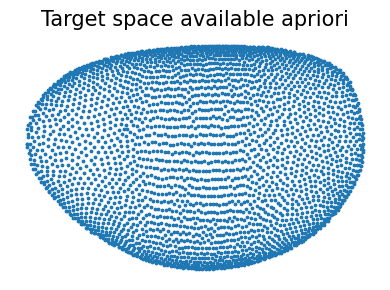

In [22]:
tit_size = 15
dpi = 100
fig, ax = plt.subplots(figsize=(4,3), dpi=dpi)

ax.scatter(locations_apriori[:, 0], locations_apriori[:, 1], s=3)

ax.set_title('Target space available apriori', size=tit_size)

ax.axis('off')

plt.tight_layout()
plt.show()

In [16]:
# download reference expression matrix 
!wget https://raw.githubusercontent.com/rajewsky-lab/novosparc/master/novosparc/datasets/bdtnp/dge.txt -O dge.txt

--2021-07-23 21:01:45--  https://raw.githubusercontent.com/rajewsky-lab/novosparc/master/novosparc/datasets/bdtnp/dge.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2269132 (2.2M) [text/plain]
Saving to: ‘dge.txt’

dge.txt             100%[===================>]   2.16M  --.-KB/s    in 0.07s   

2021-07-23 21:01:45 (31.8 MB/s) - ‘dge.txt’ saved [2269132/2269132]



In [87]:
atlas = sc.read('dge.txt')
atlas_genes = atlas.var.index.tolist()
locations = locations_apriori
atlas.obsm['spatial'] = locations

In [19]:
pl_genes = ['Antp', 'Dfd', 'ftz']

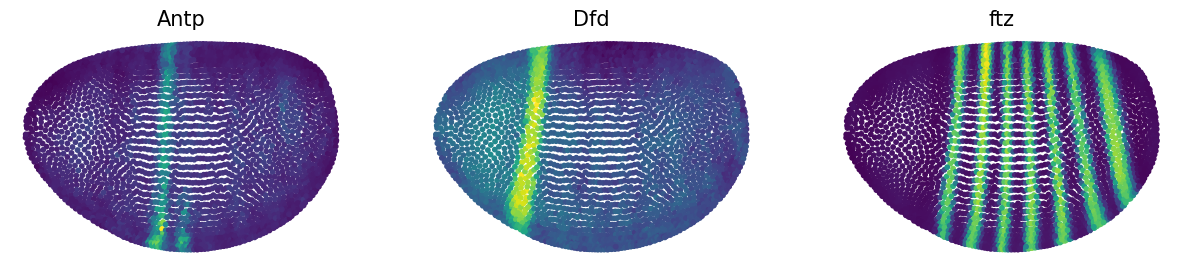

<Figure size 432x288 with 0 Axes>

In [20]:

novosparc.pl.embedding(atlas, pl_genes)

## all nuclei

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 7975 × 5999
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'X_scvi_norm', 'X_scvi_raw', 'log1p', 'norm', 'norm_log_unscaled', 'raw', 'scvi_norm_log'
    obsp: 'connectivities', 'distances'

In [23]:
dataset = adata

In [24]:
gene_names = dataset.var.index.tolist()

num_cells, num_genes = dataset.shape # 1297 cells x 8924 genes

print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)


number of cells: 8400
number of genes: 6000


In [25]:
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations)

In [26]:
# params for smooth cost
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(adata.var.gene))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)


In [27]:
# this takes ~20 minutes 
# alternative 1: setup both assumptions 
tissue.setup_reconstruction(atlas_matrix=atlas_matrix, 
                            markers_to_use=markers_to_use, 
                            num_neighbors_s=num_neighbors_s, 
                            num_neighbors_t=num_neighbors_t)

# alternative 2: handling each assumption separately
#tissue.setup_smooth_costs(dge_rep=dge_rep)
#tissue.setup_linear_cost(markers_to_use, atlas_matrix)

Setting up for reconstruction ... done ( 1059.45 seconds )


In [46]:
# this takes ~5 minutes
# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

Reconstructing spatial information with 65 markers: 8400 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


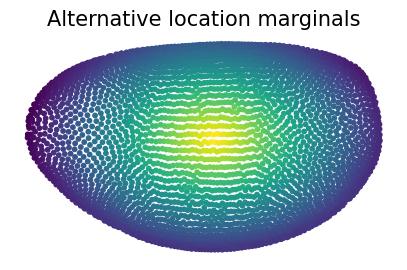

<Figure size 432x288 with 0 Axes>

In [47]:
# configure locations probability values
rdist = novosparc.gm.prob_dist_from_center(locations)
atlas.obs['Alternative location marginals'] = rdist

novosparc.pl.embedding(atlas, ['Alternative location marginals'])
#tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon, p_locations=rdist)

In [48]:
leiden_location = quantify_clusters_spatially(tissue)

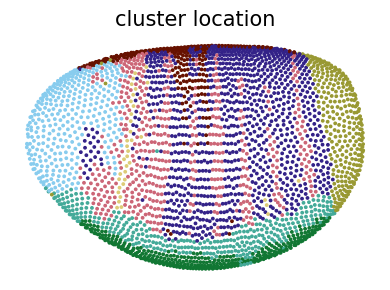

In [49]:
tit_size = 15
dpi = 100
fig, ax = plt.subplots(figsize=(4,3), dpi=dpi)

ax.scatter(locations_apriori[:, 0], locations_apriori[:, 1], c=leiden_location, cmap = my_colors, s=3)

ax.set_title('cluster location', size=tit_size)


ax.axis('off')



plt.tight_layout()
plt.show()

In [99]:
pl_genes = ['CG34250', 'Cpr73D', 'CG42741', 'ftz']

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


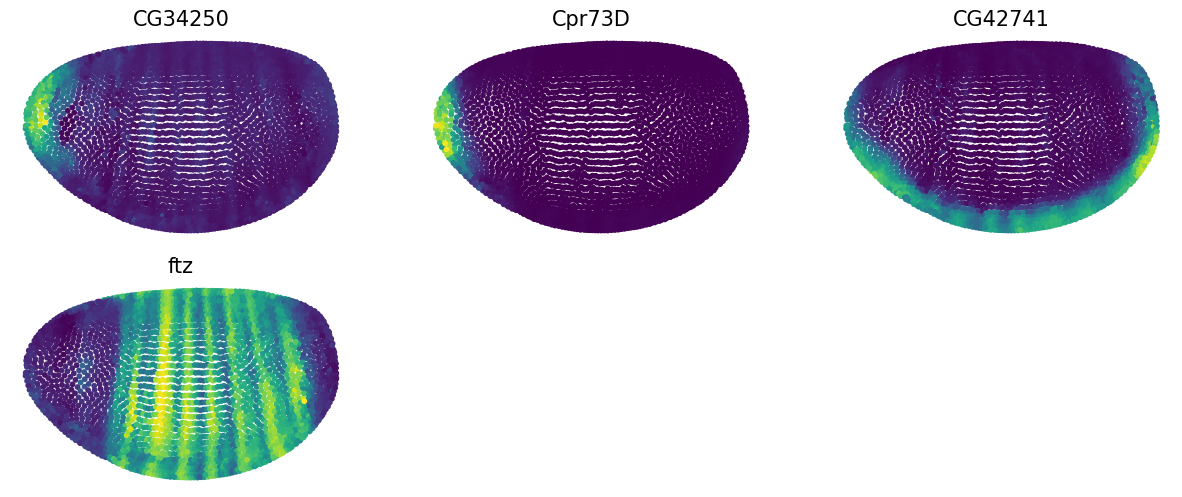

<Figure size 432x288 with 0 Axes>

In [100]:
# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations

#title = ['%s, corr=%.02f' % (g, pearsonr(dataset_reconst[:,g].X.flatten(), atlas[:,g].X.flatten())[0] ) for g in pl_genes]
novosparc.pl.embedding(dataset_reconst, pl_genes) #title=title)

In [57]:
dataset_reconst.obs.index = dataset_reconst.obs.index.map(str)

In [58]:
dataset_reconst.obs = pd.merge(pd.DataFrame(dataset_reconst.obs), df, on = dataset_reconst.obs.index)

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [59]:
dataset_reconst.obs

key_0        cell 1       cell 12  ...  archetype 7  archetype 8  archetype 9
0        0  2.696076e-12  5.348746e-12  ...    -0.000302     0.000195    -0.000224
1        1  3.994295e-14  5.404048e-15  ...    -0.000285     0.000182    -0.000247
2        2  9.937740e-13  5.784755e-14  ...    -0.000289     0.000183    -0.000236
3        3  4.764165e-15  7.531023e-16  ...    -0.000302     0.000198    -0.000262
4        4  1.526298e-13  2.306383e-12  ...    -0.000339     0.000224    -0.000246
...    ...           ...           ...  ...          ...          ...          ...
3034  3034  5.114946e-05  3.095109e-04  ...     0.000197    -0.000091    -0.000045
3035  3035  8.485580e-25  3.400915e-23  ...    -0.000403    -0.000295    -0.000125
3036  3036  1.296662e-12  3.611219e-10  ...    -0.000236     0.000073     0.000012
3037  3037  8.864377e-14  1.423562e-14  ...     0.000110     0.000036    -0.000138
3038  3038  5.464063e-03  1.427091e-09  ...     0.000255    -0.000152    -0.000048

[3039 rows x 13 columns]

Finding gene archetypes ... done


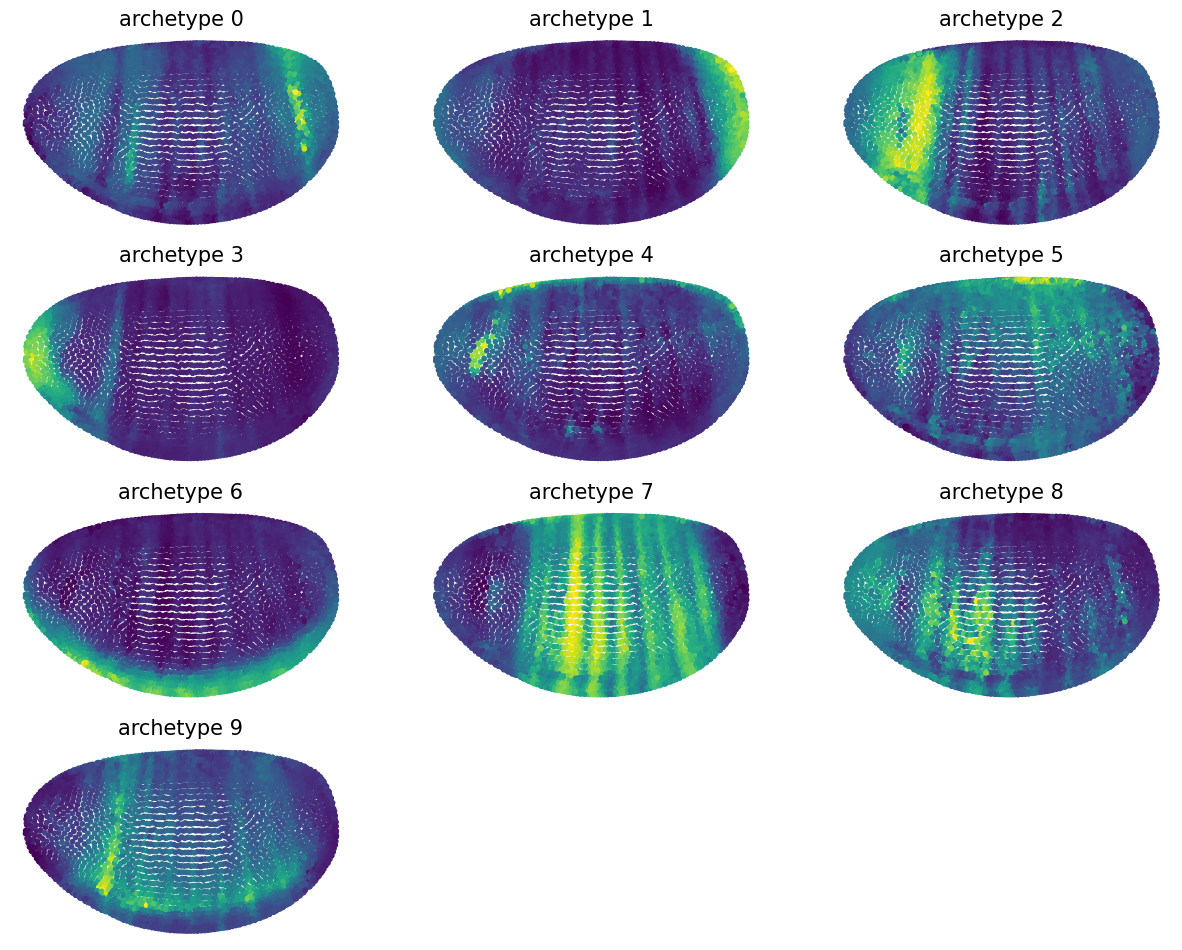

<Figure size 432x288 with 0 Axes>

In [60]:
# plot spatial expression archetypes
num_clusters = 10
atlas_indices = pd.DataFrame(np.arange(num_genes), index=gene_names)[0].loc[markers].values
archetypes, clusters, gene_corrs = novosparc.rc.find_spatial_archetypes(num_clusters, sdge[atlas_indices,:])

arch_cols = ['archetype %d'% i for i in np.arange(num_clusters)]
#dataset_reconst.obs = pd.DataFrame(index=dataset_reconst.obs.index)
df = pd.DataFrame(archetypes.T, columns=arch_cols)
#dataset_reconst.obs = pd.concat((dataset_reconst.obs, df), 1)

novosparc.pl.embedding(dataset_reconst, arch_cols)

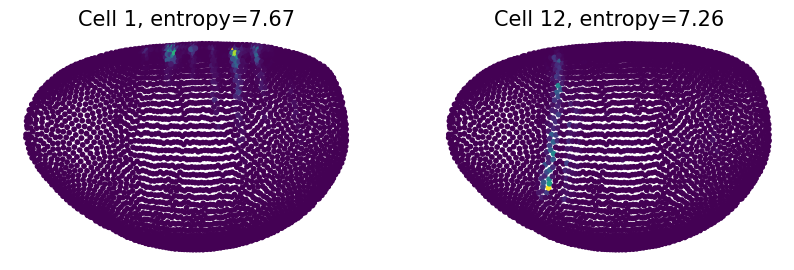

<Figure size 432x288 with 0 Axes>

In [55]:

# probability of individual cells belonging to each location
gw = tissue.gw
ngw = (gw.T / gw.sum(1)).T
cell_idx = [1, 12]
cell_prb_cols = ['cell %d' % i for i in cell_idx]
dataset_reconst.obs = pd.DataFrame(ngw.T[:, cell_idx], columns=cell_prb_cols)

title=['Cell %d, entropy=%.02f' % (i, novosparc.an.get_cell_entropy(ngw[i,:])) for i in cell_idx]
novosparc.pl.embedding(dataset_reconst, cell_prb_cols, title=title)

Reconstructing spatial information with 65 markers: 8400 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


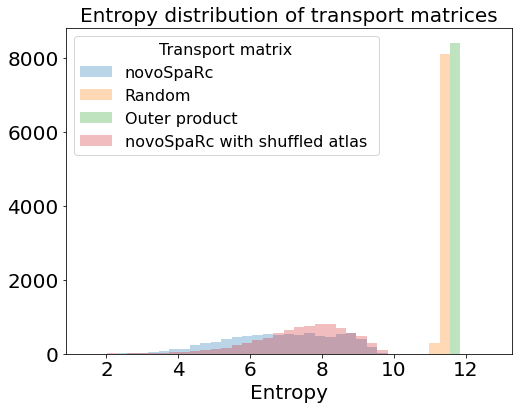

Ks_2sampResult(statistic=1.0, pvalue=0.0)
Ks_2sampResult(statistic=0.1961904761904762, pvalue=9.499067248751792e-142)


In [66]:

# comparing distributions of entropy for transporting a cell to locations
ent_T, ent_T_unif, ent_T_rproj, ent_T_shuf = novosparc.pl.plot_transport_entropy_dist(tissue)

print(ks_2samp(ent_T, ent_T_rproj))
print(ks_2samp(ent_T, ent_T_shuf))

In [70]:
!wget https://raw.githubusercontent.com/aralbright/2021_AAMSME/main/bin/singlegeneDE.csv -O singlegeneDE.csv

--2021-07-23 22:35:11--  https://raw.githubusercontent.com/aralbright/2021_AAMSME/main/bin/singlegeneDE.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4513 (4.4K) [text/plain]
Saving to: ‘singlegeneDE.csv’

singlegeneDE.csv    100%[===================>]   4.41K  --.-KB/s    in 0s      

2021-07-23 22:35:11 (44.0 MB/s) - ‘singlegeneDE.csv’ saved [4513/4513]



In [71]:
singlegeneDE = pd.read_csv('singlegeneDE.csv')

In [81]:
singlegeneDE['0']

0                numb
1                 ast
2      lncRNA:CR43857
3                 Egm
4             CG10211
            ...      
640           CG10479
641           CG11399
642            CG8800
643               twi
644               hll
Name: 0, Length: 645, dtype: object

Morans I analysis for 695 genes...

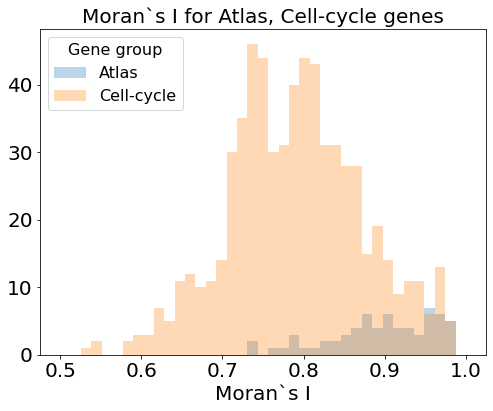

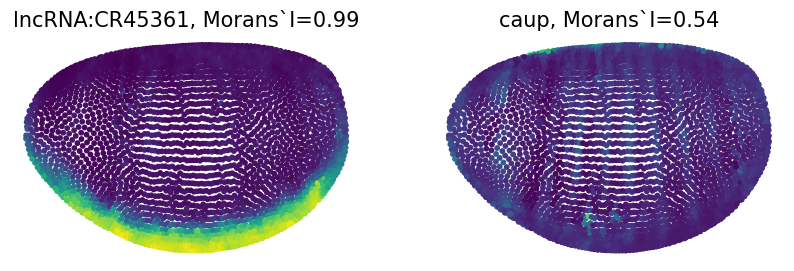

Mean Morans I for cell-cycle genes: 0.79
Mean Morans I for atlas genes: 0.90


<Figure size 432x288 with 0 Axes>

In [88]:
# Looking for spatially informative genes according to reconstruction in highly variable genes

cyc_genes = list(singlegeneDE['0'])
#[g for g in gene_names if g.startswith('Cyc')]
atlas_genes = list(set(atlas_genes).intersection(adata.var.gene))
mI_genes = cyc_genes + atlas_genes

tissue.calculate_spatially_informative_genes(mI_genes)
genes_with_scores = tissue.spatially_informative_genes

genes_with_scores.index = genes_with_scores['genes']

gene_groups = {'Atlas': atlas_genes, 'Cell-cycle': cyc_genes}
novosparc.pl.plot_morans_dists(genes_with_scores, gene_groups)

gene_max_mI = genes_with_scores['genes'].iloc[0]
gene_min_mI = genes_with_scores['genes'].iloc[-1]

title = ['%s, Morans`I=%.02f' % (gene_max_mI, genes_with_scores.loc[gene_max_mI]['mI']), 
         '%s, Morans`I=%.02f' % (gene_min_mI, genes_with_scores.loc[gene_min_mI]['mI'])]

novosparc.pl.embedding(dataset_reconst, [gene_max_mI, gene_min_mI], title=title)

print('Mean Morans I for cell-cycle genes: %.02f' % genes_with_scores.loc[cyc_genes]['mI'].mean())
print('Mean Morans I for atlas genes: %.02f' % genes_with_scores.loc[atlas_genes]['mI'].mean())

In [93]:
genes_with_scores.head(50)

genes        mI  pval
genes                                         
lncRNA:CR45361  lncRNA:CR45361  0.986568   0.0
NetA                      NetA  0.981593   0.0
fkh                        fkh  0.980866   0.0
CadN                      CadN  0.980487   0.0
Cyp310a1              Cyp310a1  0.979498   0.0
hkb                        hkb  0.975260   0.0
Cpr73D                  Cpr73D  0.974738   0.0
twi                        twi  0.974707   0.0
CG32052                CG32052  0.974573   0.0
CG42741                CG42741  0.974347   0.0
hll                        hll  0.974343   0.0
sna                        sna  0.973511   0.0
out                        out  0.973434   0.0
Mdr49                    Mdr49  0.972923   0.0
lncRNA:CR45519  lncRNA:CR45519  0.968811   0.0
lncRNA:CR44683  lncRNA:CR44683  0.968074   0.0
croc                      croc  0.967704   0.0
Lgr1                      Lgr1  0.967612   0.0
Ilp4                      Ilp4  0.967479   0.0
CG42260                CG42260  0.966014   0.0
CG34347                CG34347  0.965654   0.0
htl                        htl  0.965201   0.0
CG11905                CG11905  0.964993   0.0
neur                      neur  0.964257   0.0
tll                        tll  0.962416   0.0
cnc                        cnc  0.960796   0.0
pio                        pio  0.960667   0.0
srp                        srp  0.959457   0.0
CG9005                  CG9005  0.958853   0.0
CCY                        CCY  0.957706   0.0
numb                      numb  0.956297   0.0
ImpE2                    ImpE2  0.955980   0.0
noc                        noc  0.955613   0.0
disco                    disco  0.953614   0.0
CG7900                  CG7900  0.953382   0.0
Wnt6                      Wnt6  0.953146   0.0
kni                        kni  0.949049   0.0
CG11668                CG11668  0.947903   0.0
CG14687                CG14687  0.947849   0.0
frma                      frma  0.947779   0.0
ORY                        ORY  0.947514   0.0
Pka-C2                  Pka-C2  0.947362   0.0
oc                          oc  0.947298   0.0
CG34250                CG34250  0.947163   0.0
CG42342                CG42342  0.945954   0.0
CG40486                CG40486  0.945710   0.0
eve                        eve  0.943141   0.0
lncRNA:CR44909  lncRNA:CR44909  0.942496   0.0
D                            D  0.938275   0.0
CG13185                CG13185  0.936052   0.0

[]

## adata[adata.obs.batch =="0"]

In [101]:
dataset = adata[adata.obs.batch == '0']

In [102]:
gene_names = dataset.var.index.tolist()

num_cells, num_genes = dataset.shape 

print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)


number of cells: 4079
number of genes: 6000


In [103]:
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations)

In [104]:
# params for smooth cost
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(adata.var.gene))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# alternative 1: setup both assumptions 
tissue.setup_reconstruction(atlas_matrix=atlas_matrix, 
                            markers_to_use=markers_to_use, 
                            num_neighbors_s=num_neighbors_s, 
                            num_neighbors_t=num_neighbors_t)

# alternative 2: handling each assumption separately
#tissue.setup_smooth_costs(dge_rep=dge_rep)
#tissue.setup_linear_cost(markers_to_use, atlas_matrix)

Setting up for reconstruction ... done ( 260.38 seconds )


In [105]:
# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

Reconstructing spatial information with 65 markers: 4079 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


In [107]:
leiden_location = quantify_clusters_spatially(tissue)

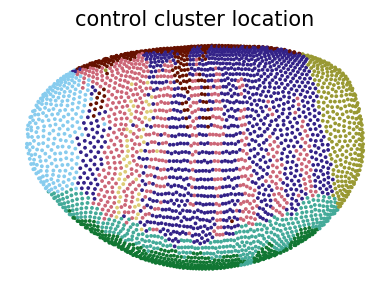

In [108]:
tit_size = 15
dpi = 100
fig, ax = plt.subplots(figsize=(4,3), dpi=dpi)

ax.scatter(locations_apriori[:, 0], locations_apriori[:, 1], c=leiden_location, cmap = my_colors, s=3)

ax.set_title('control cluster location', size=tit_size)


ax.axis('off')



plt.tight_layout()
plt.show()

In [109]:
pl_genes = ['bowl', 'oc', 'mnd','Esp', 'net', 'Atet', 'stumps', 'Mes2']

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


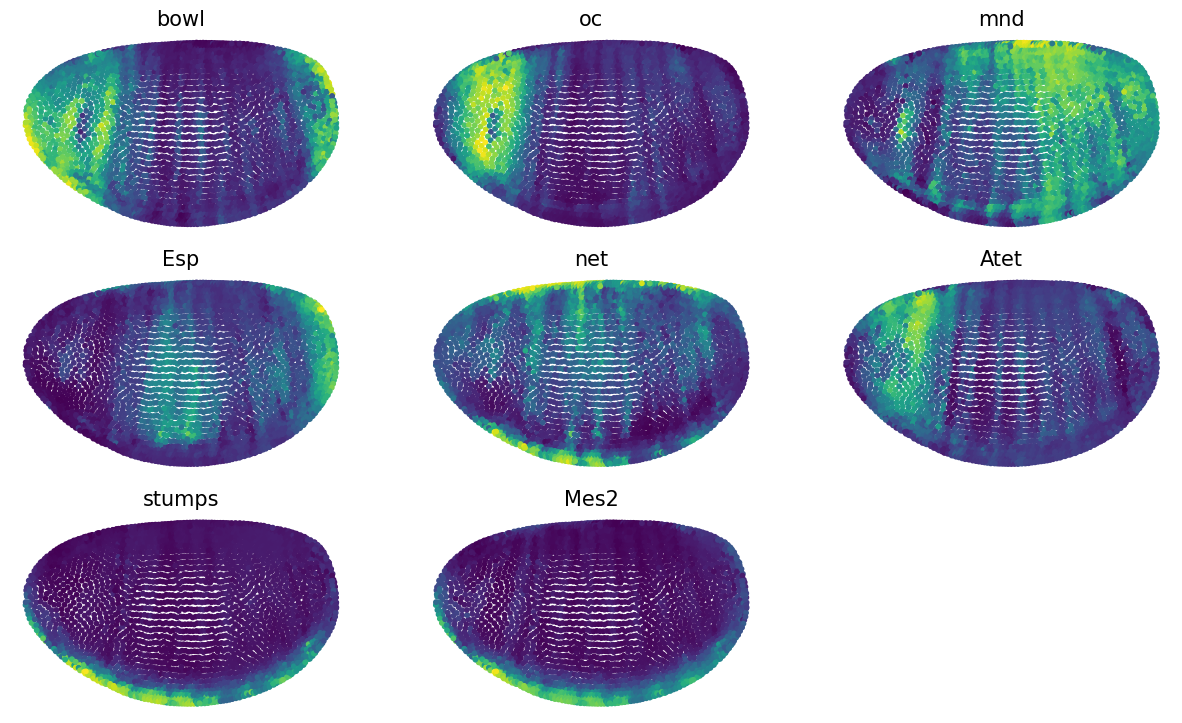

<Figure size 432x288 with 0 Axes>

In [110]:
# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations

#title = ['%s, corr=%.02f' % (g, pearsonr(dataset_reconst[:,g].X.flatten(), atlas[:,g].X.flatten())[0] ) for g in pl_genes]

novosparc.pl.embedding(dataset_reconst, pl_genes)
#novosparc.pl.embedding(dataset_reconst, leiden_location)

In [111]:
pl_genes = ['Antp', 'ftz', 'Dfd']

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


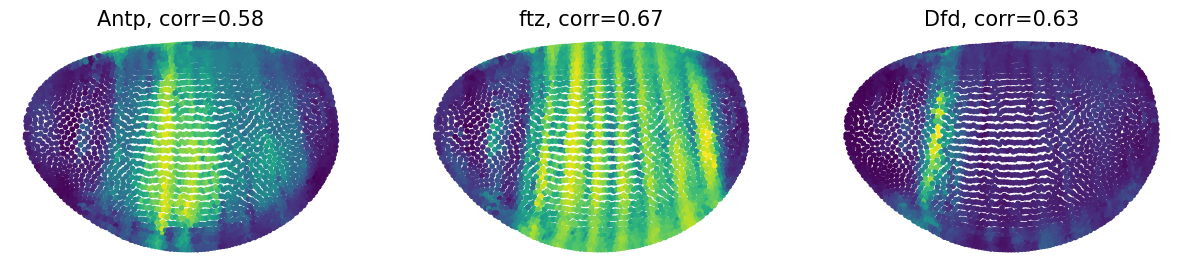

<Figure size 432x288 with 0 Axes>

In [112]:
# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations

title = ['%s, corr=%.02f' % (g, pearsonr(dataset_reconst[:,g].X.flatten(), atlas[:,g].X.flatten())[0] ) for g in pl_genes]

novosparc.pl.embedding(dataset_reconst, pl_genes, title = title)

Reconstructing spatial information with 65 markers: 4079 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


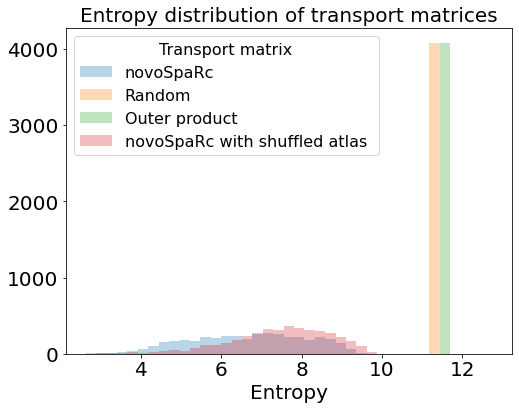

Ks_2sampResult(statistic=1.0, pvalue=0.0)
Ks_2sampResult(statistic=0.2405001225790635, pvalue=6.906541550123868e-104)


In [113]:
# comparing distributions of entropy for transporting a cell to locations
ent_T, ent_T_unif, ent_T_rproj, ent_T_shuf = novosparc.pl.plot_transport_entropy_dist(tissue)

print(ks_2samp(ent_T, ent_T_rproj))
print(ks_2samp(ent_T, ent_T_shuf))

## adata[adata.obs.batch =="1"]

In [116]:
dataset = adata[adata.obs.batch == '1']

In [117]:
gene_names = dataset.var.index.tolist()

num_cells, num_genes = dataset.shape 

print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)


number of cells: 4321
number of genes: 6000


In [118]:
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations)

In [119]:
# params for smooth cost
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(adata.var.gene))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# alternative 1: setup both assumptions 
tissue.setup_reconstruction(atlas_matrix=atlas_matrix, 
                            markers_to_use=markers_to_use, 
                            num_neighbors_s=num_neighbors_s, 
                            num_neighbors_t=num_neighbors_t)

# alternative 2: handling each assumption separately
#tissue.setup_smooth_costs(dge_rep=dge_rep)
#tissue.setup_linear_cost(markers_to_use, atlas_matrix)

Setting up for reconstruction ... done ( 289.8 seconds )


In [120]:
# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

Reconstructing spatial information with 65 markers: 4321 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


In [122]:
leiden_location = quantify_clusters_spatially(tissue)

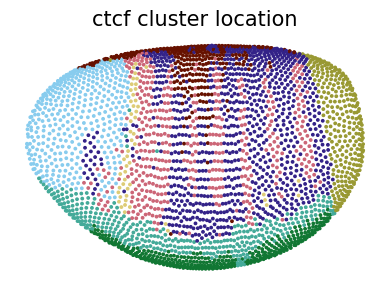

In [123]:
tit_size = 15
dpi = 100
fig, ax = plt.subplots(figsize=(4,3), dpi=dpi)

ax.scatter(locations_apriori[:, 0], locations_apriori[:, 1], c=leiden_location, cmap = my_colors, s=3)

ax.set_title('ctcf cluster location', size=tit_size)


ax.axis('off')



plt.tight_layout()
plt.show()

In [136]:
pl_genes = ['bowl', 'oc', 'mnd','Esp', 'net', 'Atet', 'stumps', 'Mes2']

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


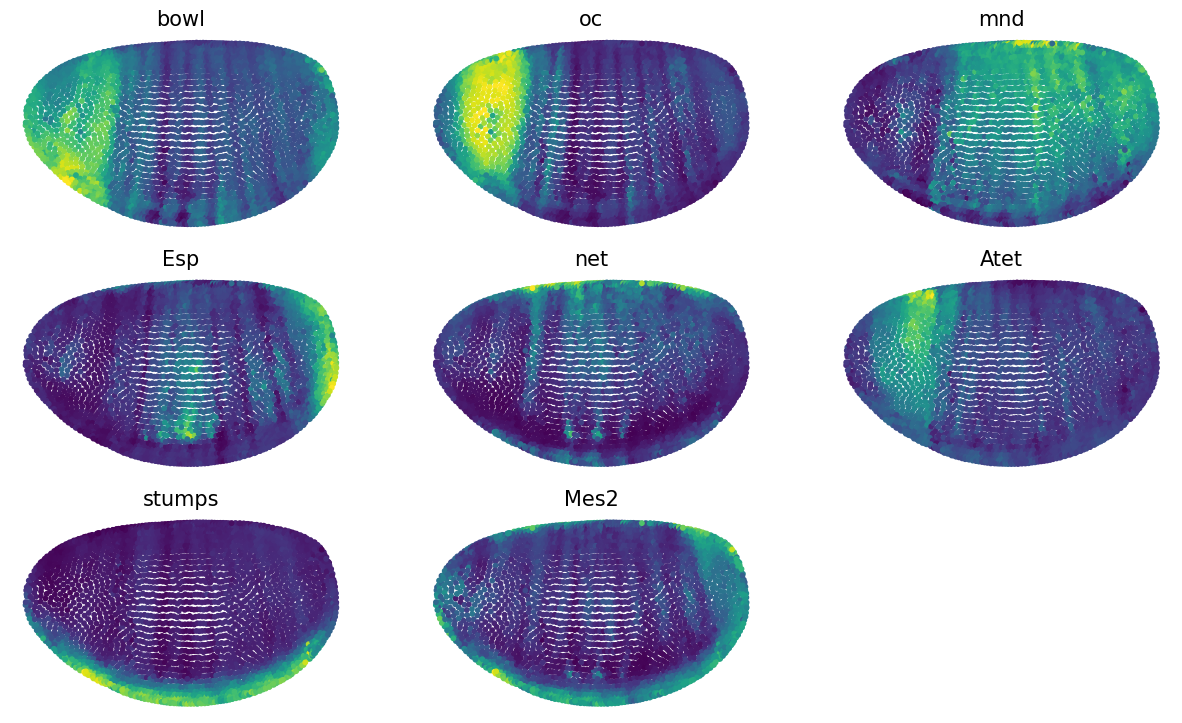

<Figure size 432x288 with 0 Axes>

In [137]:
# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations

#title = ['%s, corr=%.02f' % (g, pearsonr(dataset_reconst[:,g].X.flatten(), atlas[:,g].X.flatten())[0] ) for g in pl_genes]
novosparc.pl.embedding(dataset_reconst, pl_genes)

Reconstructing spatial information with 65 markers: 4321 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


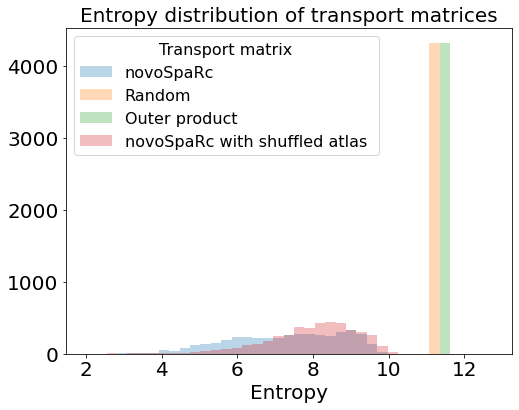

Ks_2sampResult(statistic=1.0, pvalue=0.0)
Ks_2sampResult(statistic=0.2207822263364962, pvalue=1.2023744969564952e-92)


In [131]:
# comparing distributions of entropy for transporting a cell to locations
ent_T, ent_T_unif, ent_T_rproj, ent_T_shuf = novosparc.pl.plot_transport_entropy_dist(tissue)

print(ks_2samp(ent_T, ent_T_rproj))
print(ks_2samp(ent_T, ent_T_shuf))